## **Penguins species extraction**

In this notebook we take a dataset that contains culmen length and depth, flipper length, bmi and gender of a penguin and the task is to exctrat different sub-species od penguins based on given characteristics. In the approach we will focus on unsupervised ML methods as well as technology of dimensionality reduction.

## Impotrs

In [145]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster import hierarchy
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.metrics import silhouette_score

from sklearn.neighbors import KNeighborsClassifier




## Load data

In [85]:
df = pd.read_csv('penguins.csv')
df

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,gender
0,39.1,18.7,181.0,3750.0,MALE
1,NaN,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,36.7,19.3,193.0,3450.0,FEMALE
4,39.3,20.6,190.0,3650.0,MALE
...,...,...,...,...,...
327,47.2,13.7,214.0,4925.0,FEMALE
328,NaN,NaN,215.0,4850.0,FEMALE
329,50.4,15.7,222.0,5750.0,MALE
330,45.2,14.8,212.0,5200.0,FEMALE


## **EDA (Exploratory data analysis)**

## Getting insights about the dataset

In [86]:
df.shape

(332, 5)

This means that this dataset has 332 rows and 5 columns.

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   328 non-null    float64
 1   culmen_depth_mm    329 non-null    float64
 2   flipper_length_mm  327 non-null    float64
 3   body_mass_g        332 non-null    float64
 4   gender             331 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.1+ KB


Here we can see the columns and their data types. If we look closer to the Not-Null Count and amount of entries we have we can see that there is a little amount of missing values in everyt column except bmi

In [88]:
data_types = df.dtypes
column_names = df.columns
num_columns = []
for column in column_names:
    if data_types[column] == 'object':
        print(f"Column name is: {column}")
        print('This column contains categorical data')
        print(f"And the uniques values are:\n{df[column].unique()}\n")
    else:
        num_columns.append(column)
print(f'This columns contain numerical data:\n{num_columns}')

Column name is: gender
This column contains categorical data
And the uniques values are:
['MALE' 'FEMALE' nan]

This columns contain numerical data:
['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']


As we can see the only gender column is the one that we will have to encode. It is shown again that there are missing values in the gender column.

## Fixing missing values

Check for missing values

In [89]:
print(df.isnull().sum())
print(f'\nThere is no NA values in our dataset: {df.shape == df.dropna().shape}')

culmen_length_mm     4
culmen_depth_mm      3
flipper_length_mm    5
body_mass_g          0
gender               1
dtype: int64

There is no NA values in our dataset: False


We can see that we have 1 categorical and 12 numerical missing values. We will fill them with mode and median accordingly

In [90]:

# splitting before imputing
X_cat = df[['gender']]
X_num = df.drop(columns='gender')
X_num_columns = X_num.columns.to_list()

In [91]:
# imputing seperate types of data
imp_cat = SimpleImputer(strategy='most_frequent')
imp_num = SimpleImputer(strategy='median')

X_cat = imp_cat.fit_transform(X_cat)
X_num = imp_num.fit_transform(X_num)

#combining values back to a df with encoding of categorical column
df = pd.DataFrame(X_num,columns= X_num_columns)
df['gender'] = list(map(lambda x: 0 if x[0] == 'MALE' else 1 ,X_cat.tolist()))

Let's check again for missing values

In [92]:
print(df.isnull().sum())
print(f'\nThere is no NA values in our dataset: {df.shape == df.dropna().shape}')

culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
gender               0
dtype: int64

There is no NA values in our dataset: True


## Outliers

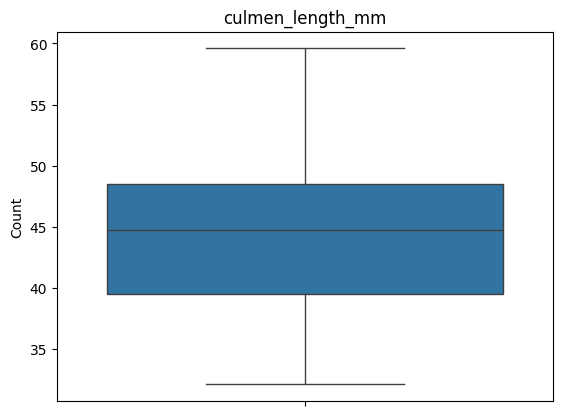

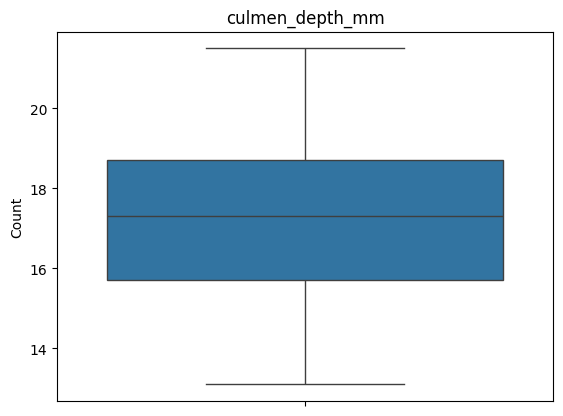

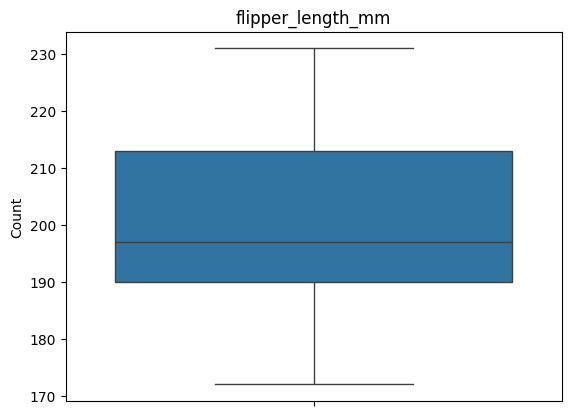

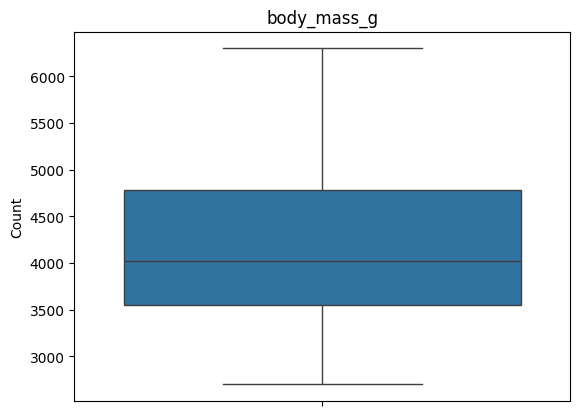

In [93]:
column_names = df.columns.to_list()

for column in column_names:
    if data_types[column] != 'object':
        figure_outlies = sns.boxplot(data=df[column])
        figure_outlies.set_title(f'{column}')
        figure_outlies.set_ylabel('Count')
    plt.show()

As these boxplot show there is no outliers in our dataset

## Statistical characteristics

Now when we are sure that there is no missiong values in our dataset we can explore the statistics

In [94]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
culmen_length_mm,332.0,44.014759,5.433503,32.1,39.5,44.7,48.525,59.6
culmen_depth_mm,332.0,17.176205,1.945917,13.1,15.7,17.3,18.700,21.5
flipper_length_mm,332.0,201.132530,13.910609,172.0,190.0,197.0,213.000,231.0
body_mass_g,332.0,4206.475904,806.361278,2700.0,3550.0,4025.0,4781.250,6300.0
gender,332.0,0.493976,0.500718,0.0,0.0,0.0,1.000,1.0


Nothing out of the ordinary is seen in statistical characteristics

## Univariate analysis

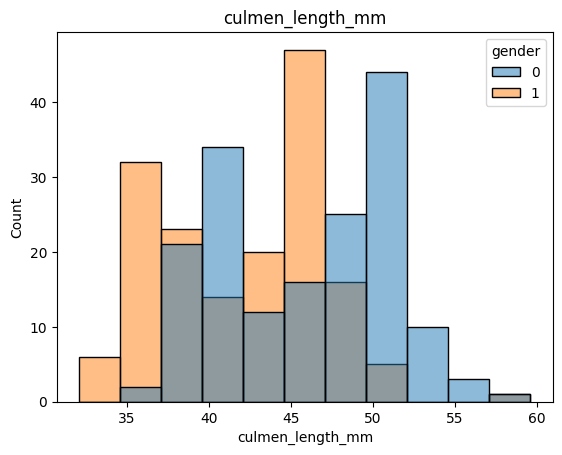

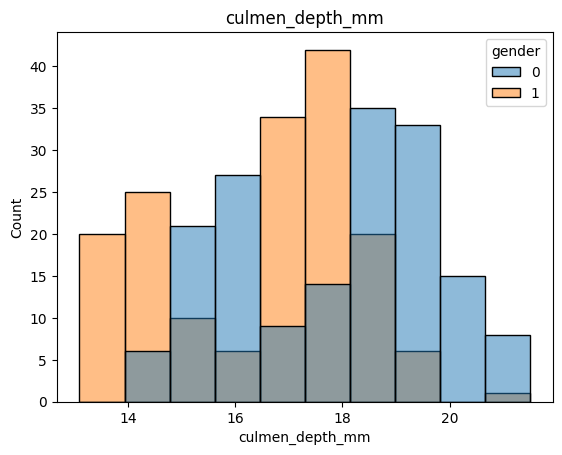

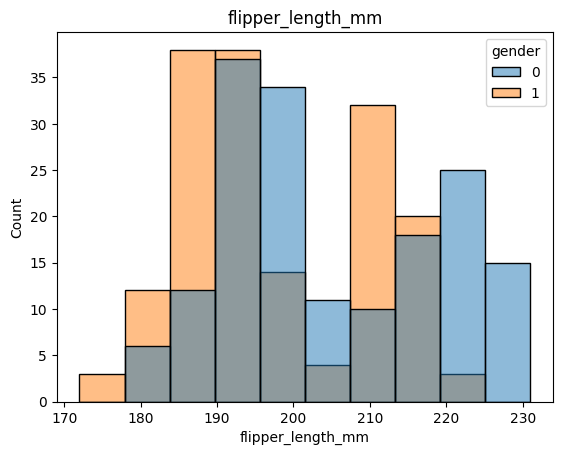

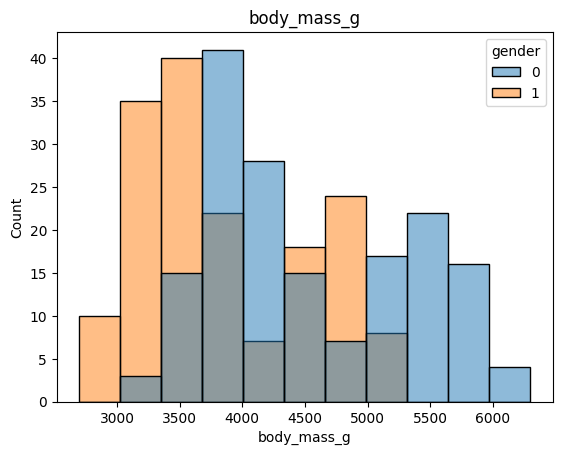

Text(0, 0.5, 'Count')

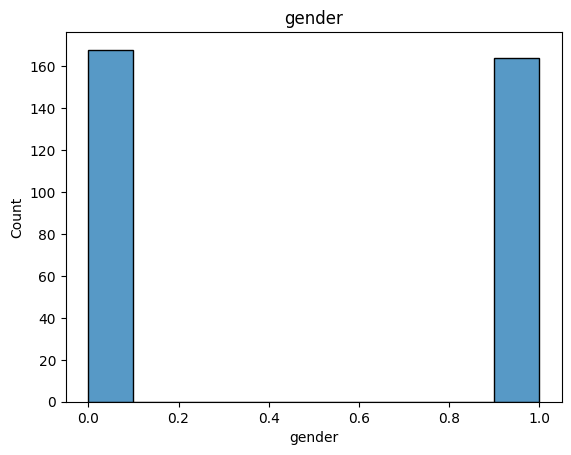

In [95]:
for column in column_names:
    if column == 'gender':
        continue
    figure = sns.histplot(data=df[[column,'gender']],hue='gender',x=column)
    figure.set_title(f'{column}')
    figure.set_ylabel('Count')
    plt.show()

figure = sns.histplot(data=df['gender'])
figure.set_title('gender')
figure.set_ylabel('Count')

#TODO: Fix legend from 0,1 to Male, Females
    

## Multivariate analysis

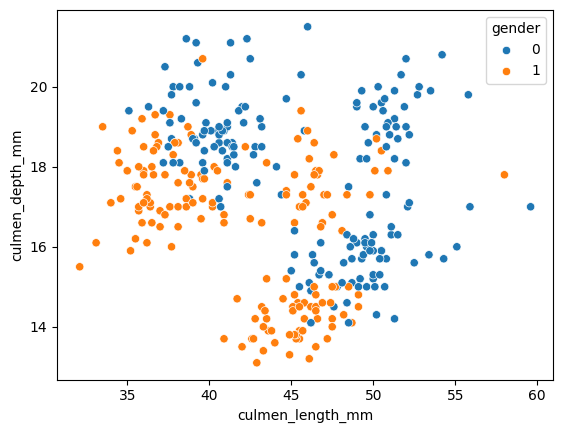

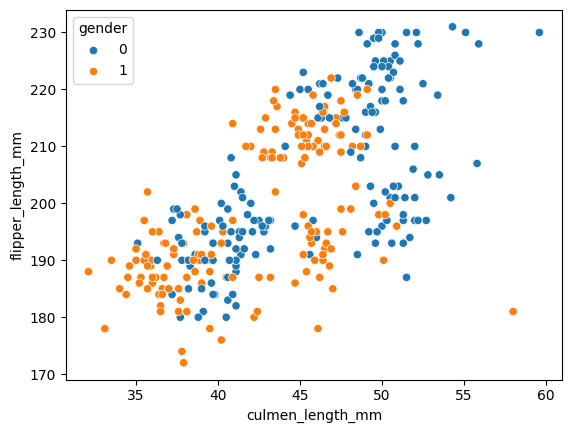

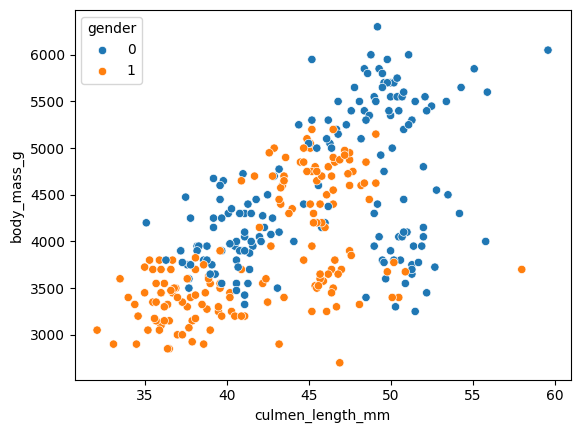

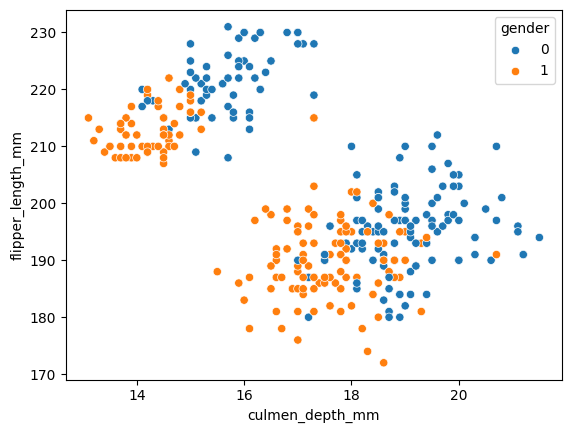

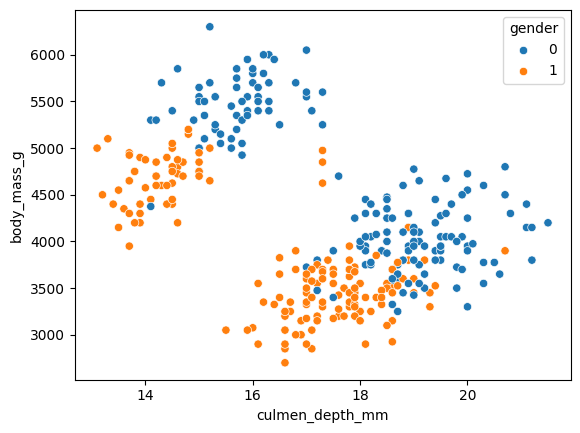

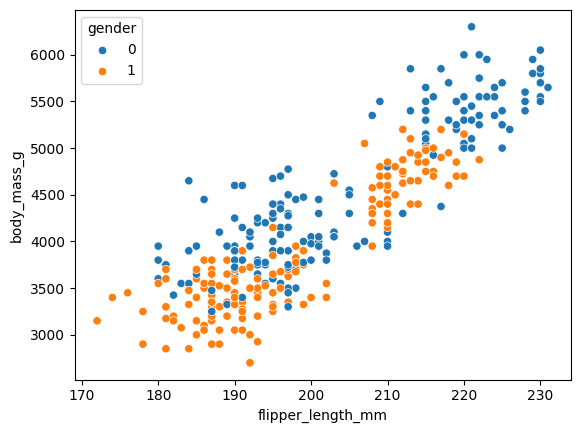

In [96]:
column_names_no_gender = column_names[:-1]
column_names_no_gender_len = len(column_names_no_gender)

for i in range(column_names_no_gender_len):
    for j in range(i,column_names_no_gender_len):
        if column_names_no_gender[i] == column_names_no_gender[j]:
            continue
        sns.scatterplot(data = df, x = df[column_names_no_gender[i]], y = df[column_names_no_gender[j]],hue='gender')
        plt.show()

As we can see on scatterplots some of the relations shows us pretty clear separation in clusters

Dendogram

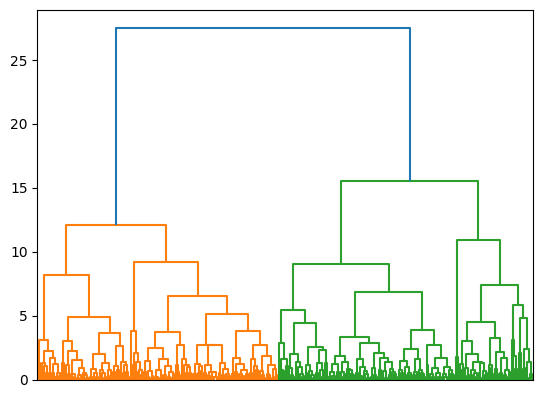

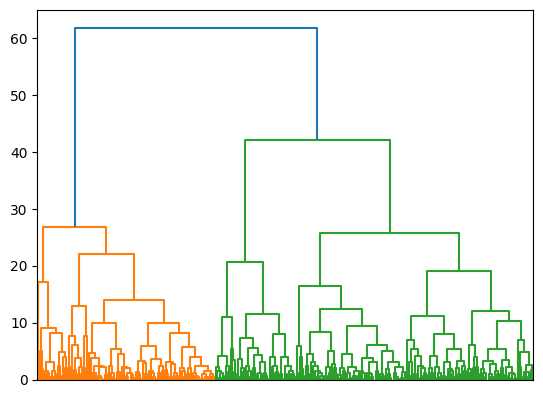

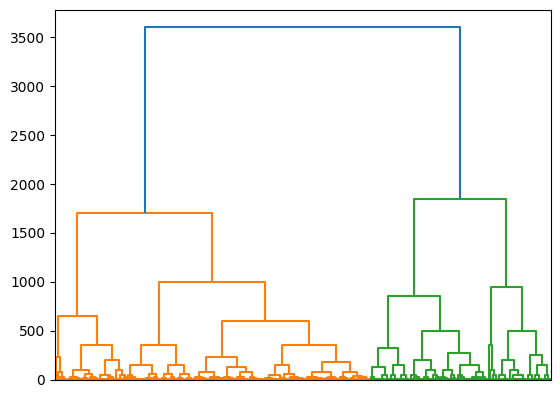

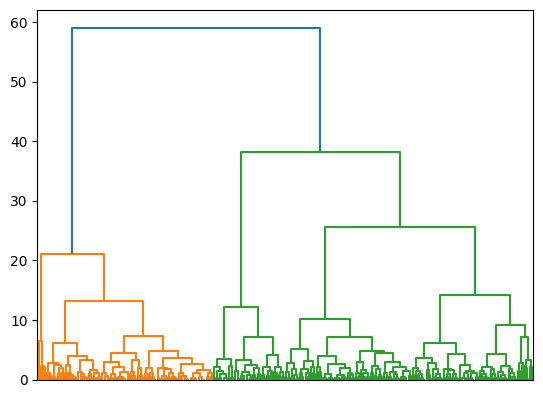

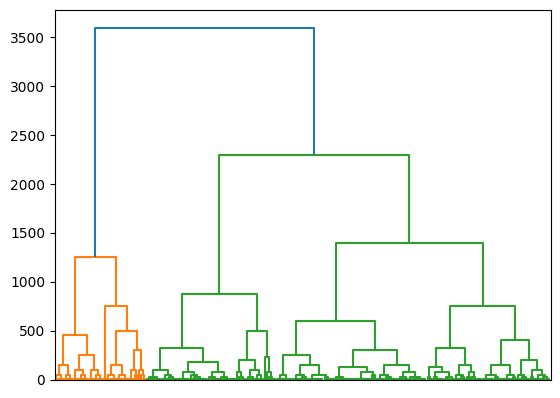

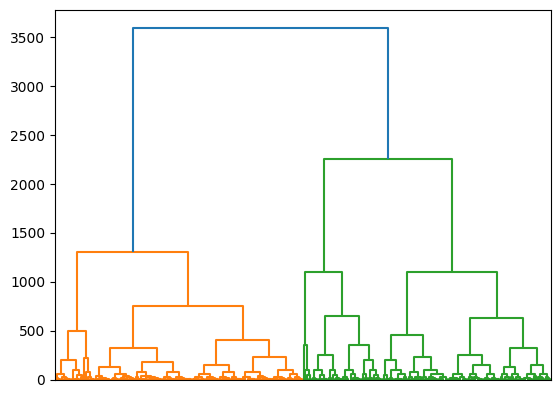

In [97]:
for i in range(column_names_no_gender_len):
    for j in range(i,column_names_no_gender_len):
        if column_names_no_gender[i] == column_names_no_gender[j]:
            continue
        mergings = hierarchy.linkage(df[[column_names_no_gender[i],column_names_no_gender[j]]], method='complete')
        hierarchy.dendrogram(mergings,no_labels = True)
        plt.show()

What we can see from the dendograms is that there are resonably separated ~2-4 clusters in between every 2 of characteristics.

## **Demensionality reduction**

## PCA (No scaling)

In [98]:
pca = PCA(n_components = 2,random_state=42)
df_reduced_no_scaling = pca.fit_transform(df)
df_reduced_no_scaling = pd.DataFrame(df_reduced_no_scaling,columns=['PC1','PC2'])
df_reduced_no_scaling

,PC1,PC2
0,-456.745233,-13.584727
1,-406.652339,-7.777172
2,-956.466988,7.935663
3,-756.537554,1.690918
4,-556.598319,-3.603298
...,...,...
327,718.646811,2.246062
328,643.657099,3.279011
329,1543.677131,-2.278874
330,993.573626,-4.660453


PCA (with scaling)

In [99]:
scalar = StandardScaler() 
df_scaled = pd.DataFrame(scalar.fit_transform(df)) #scaling the data
df_scaled

,0,1,2,3,4
0,-0.905894,0.784255,-1.449463,-0.566948,-0.988024
1,0.126304,0.115181,-1.089483,-0.504847,1.012122
2,-0.684709,0.423985,-0.441518,-1.187953,1.012122
3,-1.348265,1.093059,-0.585510,-0.939551,1.012122
4,-0.869030,1.762132,-0.801499,-0.691149,-0.988024
...,...,...,...,...,...
327,0.587107,-1.789106,0.926408,0.892415,1.012122
328,0.126304,0.063714,0.998404,0.799264,1.012122
329,1.176935,-0.759762,1.502376,1.917074,-0.988024
330,0.218465,-1.222967,0.782415,1.233968,1.012122


In [100]:
pca = PCA(n_components = 2,random_state=42)
df_reduced_with_scaling = pca.fit_transform(df_scaled)
df_reduced_with_scaling = pd.DataFrame(df_reduced_with_scaling,columns=['PC1','PC2'])
df_reduced_with_scaling

,PC1,PC2
0,-1.569421,-1.195970
1,-1.113743,0.535408
2,-1.601854,0.570521
3,-2.068787,0.227062
4,-1.576290,-1.775340
...,...,...
327,1.631918,1.867952
328,0.803071,0.741776
329,2.934477,-0.336221
330,1.385914,1.535393


Now let's check if our PCA was performed correctly

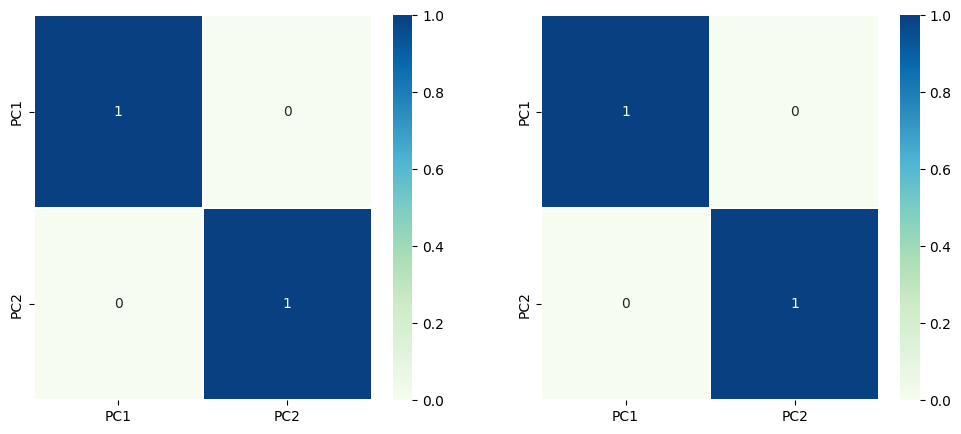

In [101]:
corr_matrix_no_scaling = df_reduced_no_scaling.corr().abs().round(2)
corr_matrix_with_scaling = df_reduced_with_scaling.corr().abs().round(2)

figure, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(corr_matrix_no_scaling, annot=True, cmap='GnBu', linewidths=0.2, vmin=0, vmax=1,ax=axes[0])
sns.heatmap(corr_matrix_with_scaling, annot=True, cmap='GnBu', linewidths=0.2, vmin=0, vmax=1,ax=axes[1])

plt.show()

As we can see there is no correlation between new features so all the processes were correctly executed

## **Clustering algorithms experiments**

Now we are going to try a couple of clustering algorithms:
- dendogram


## Without scaling

**Dendogram**

Text(0.5, 1.0, 'Dendogram Clustering')

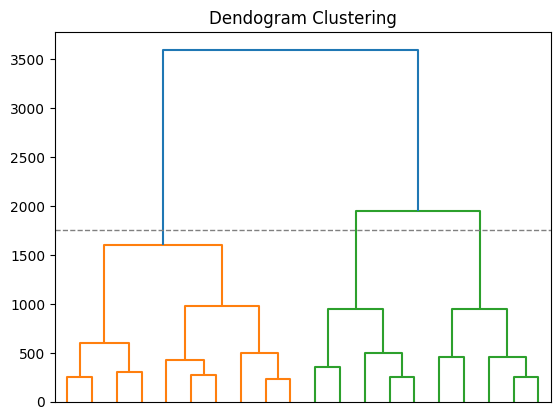

In [102]:
mergings = hierarchy.linkage(df_reduced_no_scaling, method='complete')
hierarchy.dendrogram(mergings,no_labels = True,p=20,truncate_mode='lastp',)
plt.axhline(y=1750, c='grey', lw=1, linestyle='dashed')
plt.title('Dendogram Clustering')

With asumption that we draw a line separating the cluster around the middle of distances, we can see that our data form 3 classes. We also reduced number of leafs for better readability. But if we base judgement on colors that our dendagram produced we get 2 classes.

**K-Means**

First we are trying default values for K

Text(0.5, 1.0, 'K-means Clustering (K = 8)')

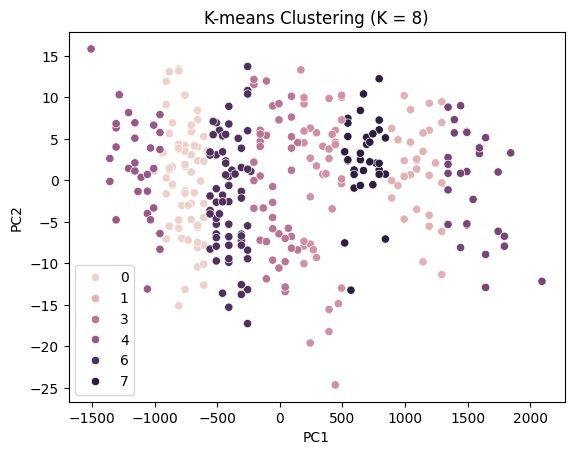

In [103]:
kmeans = KMeans(n_clusters=8, random_state=42, n_init="auto").fit(df_reduced_no_scaling)
sns.scatterplot(data = df_reduced_no_scaling, x = 'PC1', y = 'PC2', hue = kmeans.labels_)
plt.title('K-means Clustering (K = 8)')

As we can see it is not really helpfull as well as from our previous observations this does not help in separating our data

Let's find the best K by using:
- scatter plot
- inertia with using elbow point
- silhouette scores using elbow point

**scatter plot**

<Axes: xlabel='PC1', ylabel='PC2'>

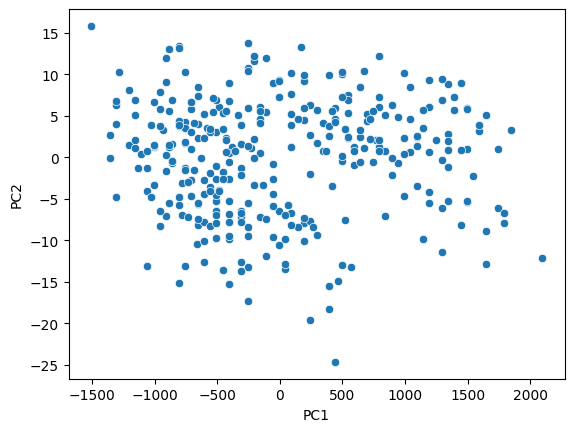

In [104]:
sns.scatterplot(data=df_reduced_no_scaling,x = 'PC1', y = 'PC2')

This approach is not very helpfull as we can hardly diffirentiate between the potential clusters

**inertia with using elbow point**

Text(0.5, 1.0, 'Elbow Method')

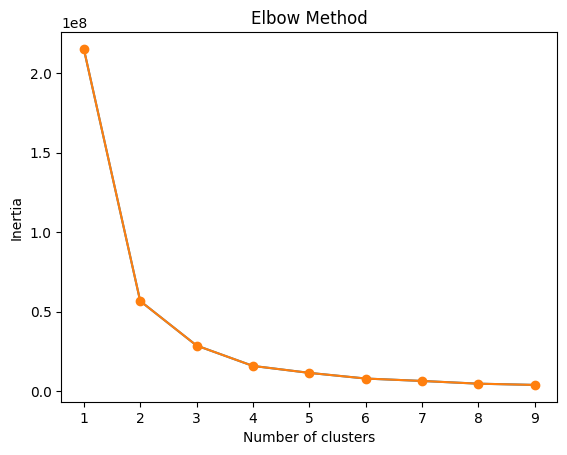

In [105]:
K = range(1, 10)
score = []

for k in K:
    model = KMeans(n_clusters = k, random_state = 42, n_init='auto').fit(df_reduced_no_scaling)
    score.append(model.inertia_)

sns.lineplot(x = K, y = score)
plt.plot(K, score, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

With this method it is really hard to tell as well where the perfect elbow is positioned. Good bets would have been 3 and 4

**silhouette score**

Text(0.5, 1.0, 'Silhouette analysis For Optimal k')

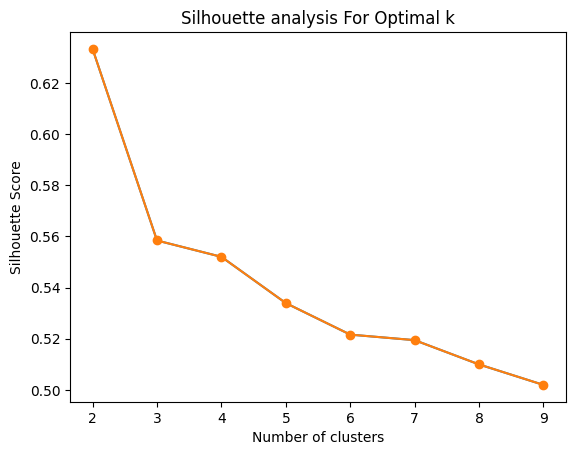

In [106]:
K = range(2, 10)
score = []

for k in K:
    model = KMeans(n_clusters = k, random_state = 42, n_init='auto').fit(df_reduced_no_scaling)
    score.append(silhouette_score(df_reduced_no_scaling, model.labels_, metric='euclidean'))

sns.lineplot(x = K, y = score)
plt.plot(K, score, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette analysis For Optimal k')

By using silhouette analysis we find that only 2 is a good option for K, because the score is in range [1,-1], where 1 means good separation in compact clusters, where values around 0 means overlaping clusters 

Now let's see the results 

K = 2

Text(0.5, 1.0, 'K-means Clustering (K = 2)')

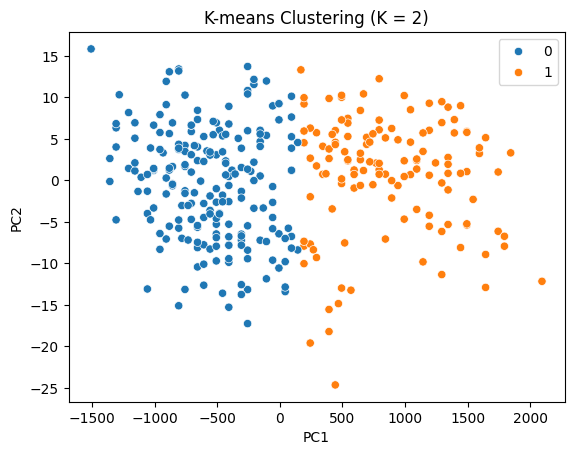

In [107]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto").fit(df_reduced_no_scaling)
sns.scatterplot(data = df_reduced_no_scaling, x = 'PC1', y = 'PC2', hue = kmeans.labels_)
plt.title('K-means Clustering (K = 2)')

K = 3

Text(0.5, 1.0, 'K-means Clustering (K = 3)')

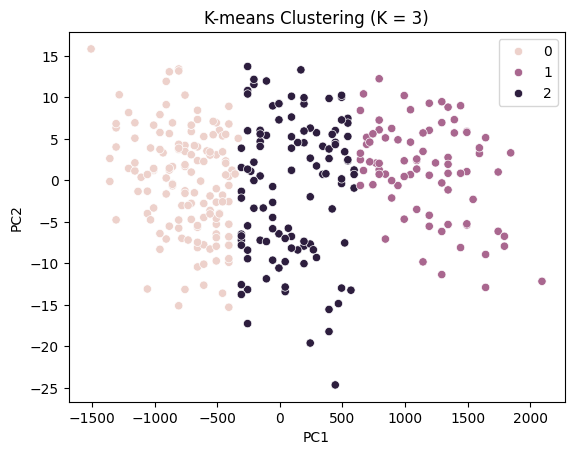

In [108]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(df_reduced_no_scaling)
sns.scatterplot(data = df_reduced_no_scaling, x = 'PC1', y = 'PC2', hue = kmeans.labels_)
plt.title('K-means Clustering (K = 3)')

K = 4

Text(0.5, 1.0, 'K-means Clustering (K = 4)')

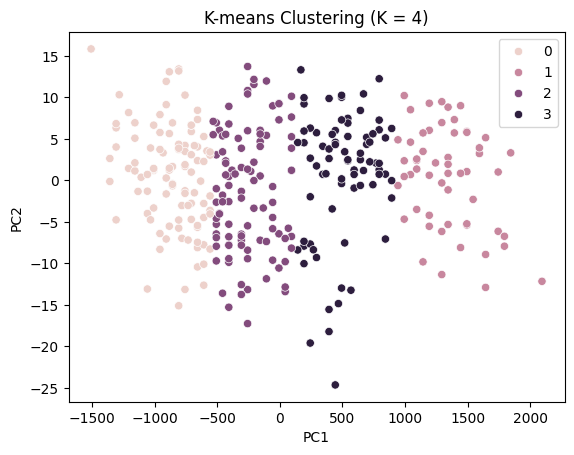

In [109]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto").fit(df_reduced_no_scaling)
sns.scatterplot(data = df_reduced_no_scaling, x = 'PC1', y = 'PC2', hue = kmeans.labels_)
plt.title('K-means Clustering (K = 4)')

This final representation is not very clear in separating clusters but it gives dedcent separation based on X axes

**DBSCAN**

Text(0.5, 1.0, 'DBSCAN Clustering (min_samples = 10)')

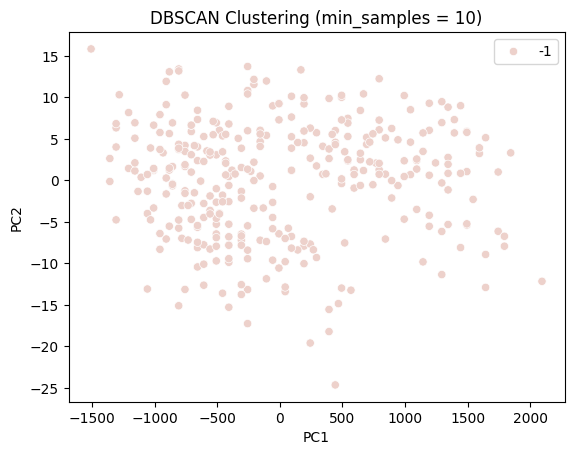

In [110]:
dbsc = DBSCAN(min_samples=10).fit(df_reduced_no_scaling)
sns.scatterplot(data = df_reduced_no_scaling, x = 'PC1', y = 'PC2', hue = dbsc.labels_)
plt.title('DBSCAN Clustering (min_samples = 10)')

As we can see without scaling DBSCAN labeled our whole data as pure noise

**MeanShift**

Text(0.5, 1.0, 'MeanShift Clustering')

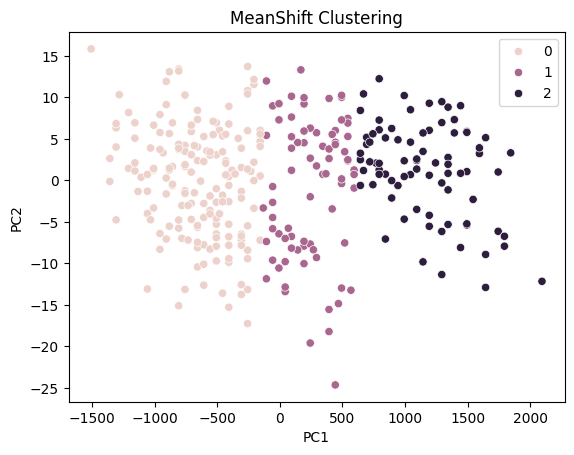

In [111]:
mean_shift = MeanShift().fit(df_reduced_no_scaling)
sns.scatterplot(data = df_reduced_no_scaling, x = 'PC1', y = 'PC2', hue = mean_shift.labels_)
plt.title('MeanShift Clustering')

Interestingly, MeanShift defines 3 clusters on unscaled data simillary to KMeans wiht K = 3

## With scaling

**Dendogram**

Text(0.5, 1.0, 'Dendogram Clustering')

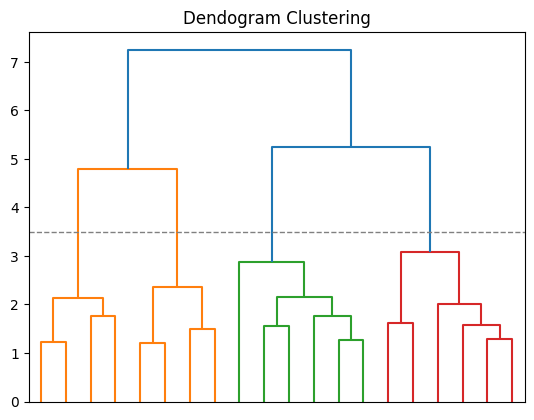

In [112]:
mergings = hierarchy.linkage(df_reduced_with_scaling, method='complete')
hierarchy.dendrogram(mergings,no_labels = True,p=20,truncate_mode='lastp',)
plt.axhline(y=3.5, c='grey', lw=1, linestyle='dashed')
plt.title('Dendogram Clustering')

With asumption that we draw a line separating the cluster around the middle of distances, we can see that our data form 4 classes. We also reduced number of leafs for better readability. But if we base judgement on colors that our dendagram produced we get 3 classes.

**K-Means**

First we are trying default values for K

Text(0.5, 1.0, 'K-means Clustering (K = 8)')

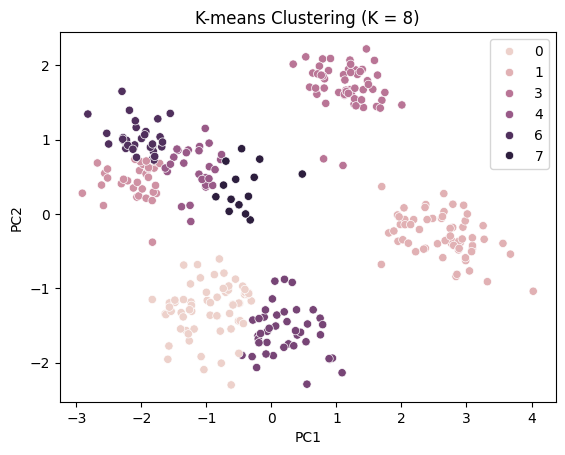

In [113]:
kmeans = KMeans(n_clusters=8, random_state=42, n_init="auto").fit(df_reduced_with_scaling)
sns.scatterplot(data = df_reduced_with_scaling, x = 'PC1', y = 'PC2', hue = kmeans.labels_)
plt.title('K-means Clustering (K = 8)')

As we can see it is not really helpfull as well because there is too much splits

Let's find the best K by using:
- scatter plot
- inertia with using elbow point
- silhouette scores

**scatter plot**

<Axes: xlabel='PC1', ylabel='PC2'>

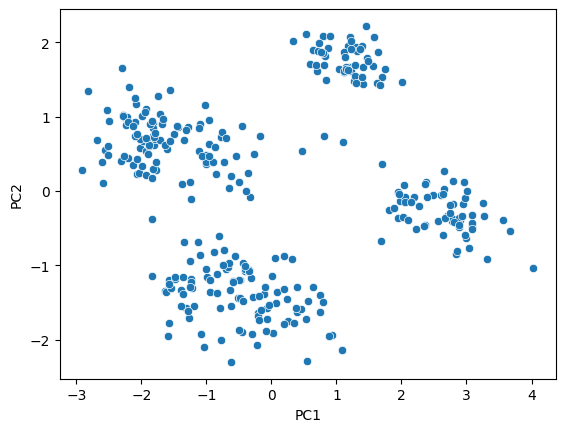

In [114]:
sns.scatterplot(data=df_reduced_with_scaling,x = 'PC1', y = 'PC2')

We can see good amount of 4 clusters 

**inertia with using elbow point**

Text(0.5, 1.0, 'Elbow Method')

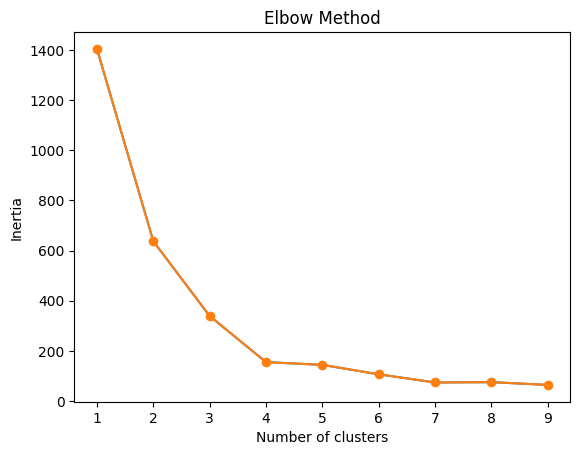

In [115]:
K = range(1, 10)
score = []

for k in K:
    model = KMeans(n_clusters = k, random_state = 42, n_init='auto').fit(df_reduced_with_scaling)
    score.append(model.inertia_)

sns.lineplot(x = K, y = score)
plt.plot(K, score, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

by using the elbow method 4 is the number for K to separating the data nicely

**silhouette score**

Text(0.5, 1.0, 'Silhouette analysis For Optimal k')

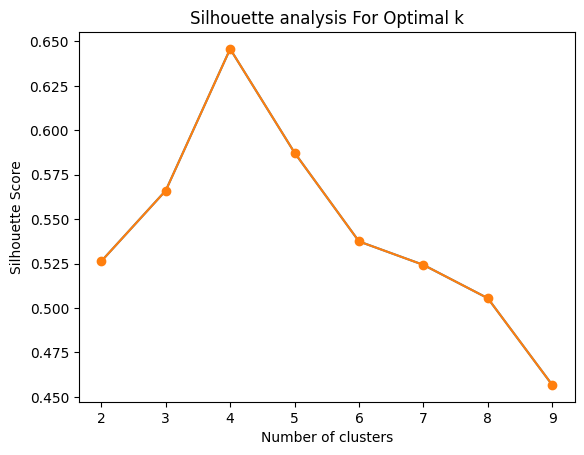

In [116]:
K = range(2, 10)
score = []

for k in K:
    model = KMeans(n_clusters = k, random_state = 42, n_init='auto').fit(df_reduced_with_scaling)
    score.append(silhouette_score(df_reduced_with_scaling, model.labels_, metric='euclidean'))

sns.lineplot(x = K, y = score)
plt.plot(K, score, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette analysis For Optimal k')

Clearly we can see that 4 is the best K for our task

Now let's see the results 

**2 clusters**

Text(0.5, 1.0, 'K-means Clustering (K = 2)')

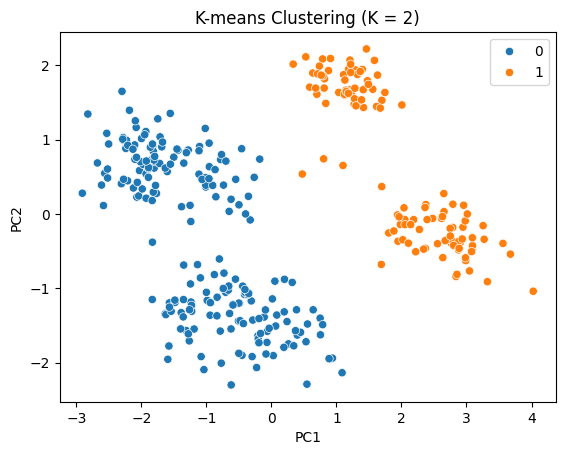

In [117]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto").fit(df_reduced_with_scaling)
sns.scatterplot(data = df_reduced_with_scaling, x = 'PC1', y = 'PC2', hue = kmeans.labels_)
plt.title('K-means Clustering (K = 2)')

There is the possibility that within one class for examle male and female are easily differentiable.

**4 clusters**

Text(0.5, 1.0, 'K-means Clustering (K = 4)')

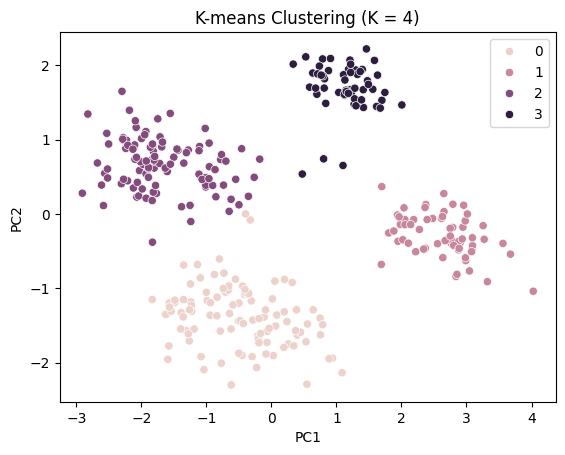

In [118]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto").fit(df_reduced_with_scaling)
sns.scatterplot(data = df_reduced_with_scaling, x = 'PC1', y = 'PC2', hue = kmeans.labels_)
plt.title('K-means Clustering (K = 4)')

The data is pretty nicely are separated in 4 clusters

**DBSCAN**

Text(0.5, 1.0, 'DBSCAN Clustering')

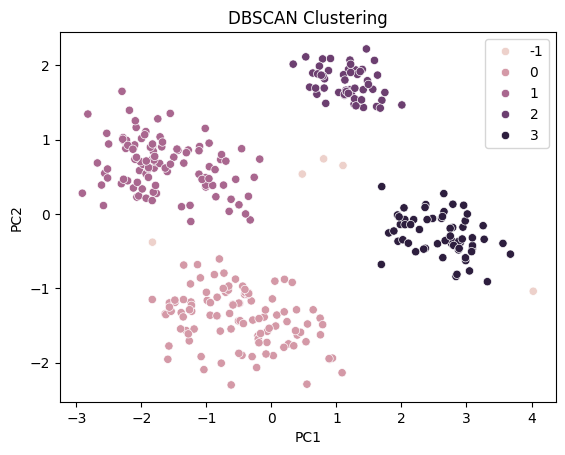

In [119]:
dbsc = DBSCAN().fit(df_reduced_with_scaling)
sns.scatterplot(data = df_reduced_with_scaling, x = 'PC1', y = 'PC2', hue = dbsc.labels_)
plt.title('DBSCAN Clustering')

When data is scaled DBSCAN clearly finds 4 clusters with a little noise in between them

**MeanShift**

<Axes: xlabel='PC1', ylabel='PC2'>

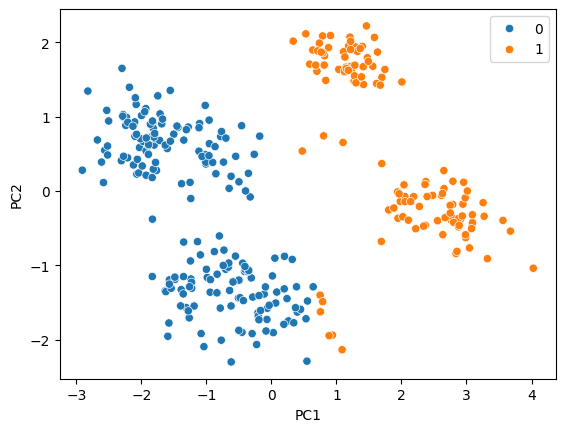

In [120]:
mean_shift = MeanShift().fit(df_reduced_with_scaling)
sns.scatterplot(data = df_reduced_with_scaling, x = 'PC1', y = 'PC2', hue = mean_shift.labels_)


On scaled data MeanShift outputs that there is 2 clusters as well

## **Experiments conclusion**

With all these tests, we found out that based on the data we have **4 breed of penguins**. Best performance (visually most logical separation shown via scatterplot) was achived with clusterization by **DBSCAN** on **scaled data**.

## **Final model**

reading original data

In [121]:
df_og = pd.read_csv('penguins.csv')

Removing missing valuse due to the small amount of them

In [122]:
print(df_og.isnull().sum())
print(f'\nThere is no NA values in our dataset: {df_og.shape == df_og.dropna().shape}')

df_og = df_og.dropna()

print(df_og.isnull().sum())
print(f'\nThere is no NA values in our dataset: {df_og.shape == df_og.dropna().shape}')

culmen_length_mm     4
culmen_depth_mm      3
flipper_length_mm    5
body_mass_g          0
gender               1
dtype: int64

There is no NA values in our dataset: False
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
gender               0
dtype: int64

There is no NA values in our dataset: True


Encoding categorical data

In [123]:
df_og['gender'] = list(map(lambda x: 0 if x == 'MALE' else 1 ,df_og['gender']))

Splitting the data

In [147]:
X_train, X_test = train_test_split(df_og,test_size=0.1,random_state=42)

Scaling both parts

In [148]:
scalar_train = StandardScaler() 
scalar_test = StandardScaler() 

X_train_scaled = pd.DataFrame(scalar_train.fit_transform(X_train)) #scaling the X_train
X_test_scaled = pd.DataFrame(scalar_test.fit_transform(X_test)) #scaling the X_test


Sequential application of PCA on both datasets

In [149]:
pca_train = PCA(n_components = 2,random_state=42)
pca_test = PCA(n_components = 2,random_state=42)

X_train_scaled_reduced = pca_train.fit_transform(X_train_scaled)
X_train_scaled_reduced = pd.DataFrame(X_train_scaled_reduced,columns=['PC1','PC2'])

X_test_scaled_reduced = pca_test.fit_transform(X_test_scaled)
X_test_scaled_reduced = pd.DataFrame(X_test_scaled_reduced,columns=['PC1','PC2'])

Applying DBSCAN

Text(0.5, 1.0, 'DBSCAN Clustering Train')

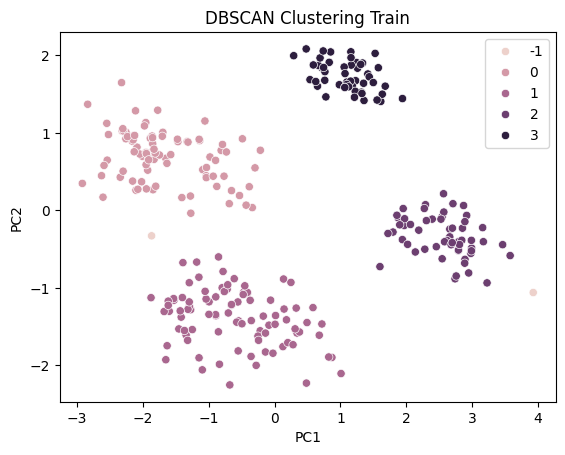

In [150]:
dbsc = DBSCAN()
dbsc_labels = dbsc.fit_predict(X_train_scaled_reduced)
sns.scatterplot(data = X_train_scaled_reduced, x = 'PC1', y = 'PC2', hue = dbsc_labels)
plt.title('DBSCAN Clustering Train')

Saving the lables

In [151]:
X_train_scaled_reduced['class'] = dbsc_labels
X_train_scaled_reduced

,PC1,PC2,class
0,-1.694642,1.006628,0
1,0.328856,-1.260409,1
2,1.940320,-0.377222,2
3,-2.310580,1.022959,0
4,-1.325596,0.887041,0
...,...,...,...
283,-0.487251,0.922863,0
284,-1.318279,-1.676601,1
285,-2.230974,0.950900,0
286,2.886149,-0.681660,2


dropping "noisy" data

In [152]:
X_train_scaled_reduced = X_train_scaled_reduced[X_train_scaled_reduced['class'] != -1]
X_train_scaled_reduced

,PC1,PC2,class
0,-1.694642,1.006628,0
1,0.328856,-1.260409,1
2,1.940320,-0.377222,2
3,-2.310580,1.022959,0
4,-1.325596,0.887041,0
...,...,...,...
283,-0.487251,0.922863,0
284,-1.318279,-1.676601,1
285,-2.230974,0.950900,0
286,2.886149,-0.681660,2


Separating labels from the data

In [133]:
classifier_y = X_train_scaled_reduced['class']
classifier_X = X_train_scaled_reduced.drop(columns=['class'])

## Build a classifier

**KNN**

training

In [153]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X=classifier_X, y=classifier_y)



KNeighborsClassifier(n_neighbors=3)

evaluating

In [155]:
cls_y_pred = knn.predict(X_test_scaled_reduced)
X_test_scaled_reduced['class'] = cls_y_pred
X_test_scaled_reduced

,PC1,PC2,class
0,1.643385,1.799812,3
1,1.654043,-2.930277,2
2,-1.446345,-0.894274,2
3,-0.980914,1.394008,0
4,0.339730,1.779323,3
5,-2.045460,-1.144576,2
6,-0.103724,1.846591,3
7,-0.259867,-0.306579,0
8,2.519915,-0.372069,1
9,1.323306,-2.016010,2


## **Classification conclusion**

Because we don't have anotated labales we cannot evaluate the model we got how good it is, because if we split our data into train and dev we will jsut get 100% accuracy because it would be a "seen" data

## **What can be improved**
- adding MaxAbsScaler and Normalizer as a potential preprocessing steps
- performing proper silhouette analysis (as shown in sckit-learn example).
- trying out t-SNE as dimensionality reduction algorithm
- making a pipeline for final model
- adding self-anotated data to evaluate classification accuracy
- other classification model to be used

## **Questions**
- is it true that we should apply demensionality reduction when we have correlation between features rather than target ones
- is there any issue to use One instance of Standrat Scaler for 2 independent sets?